# Scaling of the maximum energy vs the number of virtual orbitals for $N_2$

We consider a $N_2$ molecule and we determine the maximum energy, that is the energy of the last virtual orbital in function of the number of virtual orbitals.

In [1]:
from BigDFT import Logfiles as lf
from futile import Yaml
import matplotlib.pyplot as plt
import numpy as np
inputpath = 'testfiles/N2maxEngVorb/input/'

## Analysis for rmult =[7.0, 9.0]

First of all we define the python dictionary that contains the basic keys common to all the file in the run

In [2]:
inp0 = {'dft' : 
        {'hgrids': 0.4,
         'rmult': [7.0, 9.0],
         'inputpsiid': 2, #restart from previous wfn
         'output_wf': 2, #write wfn on disk
         #'output_denspot': 22, # save density on file
         'itermax_virt' : 100},
        'radical': 'N2_rmult7', #always in the same directory
        'posinp': 'N2_posinp.xyz'}

and we write these common variables in the default file:

In [3]:
Yaml.dump(inp0,inputpath + 'default.yaml')

Then we write a list of input file with increasing number of virtual orbitals

In [4]:
norb=[16,32,64,128,256]

In [5]:
for n in norb:
    inp={'dft':{'norbv': -n}}
    inpname = 'N2_rmult7_norb'+str(n)
    Yaml.dump(inp,inputpath + inpname + '.yaml')

We execute each file with the command:

OMP_NUM_THREADS=1 mpirun -np 8 $BIGDFT_ROOT/bigdft -d ../log/ -n namefile

Now we read the log of the simulations and plot the energy max in function of the number of virtual orbitals

In [6]:
logs = !ls testfiles/N2maxEngVorb/log/log-N2_rmult7_*
N2data=[lf.Logfile(l) for l in logs]
nRuns=len(N2data)
nRuns

5

We create the lists with the values of highest enerrgy and number of virtual orbitals_

In [7]:
Emax=[]
Norbv=[]
for n in N2data:
    Norbv.append(-n.log['dft']['norbv'])
    Emax.append(n.evals[0][0][-1])
print(Norbv)
print(Emax)

[128, 16, 256, 32, 64]
[1.1027915636540699, 0.263960940944718, 1.63042469076101, 0.34660221454630702, 0.64012205126697297]


and we sort their argument according the number ov virtual orbitals:

In [8]:
l = np.argsort(Norbv)
l

array([1, 3, 4, 0, 2])

In [9]:
E=[]
N=[]
for ind in l:
    N.append(Norbv[ind])
    E.append(Emax[ind])
print(N)
print(E)

[16, 32, 64, 128, 256]
[0.263960940944718, 0.34660221454630702, 0.64012205126697297, 1.1027915636540699, 1.63042469076101]


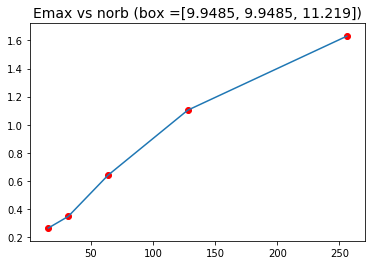

In [10]:
plt.plot(N,E)
plt.scatter(N,E, color='r')
plt.title('Emax vs norb (box ='+str(N2data[0].log['Sizes of the simulation domain']['Angstroem'])+')',fontsize=14)
plt.show()

To check for the convergence of the orbitals we perform a run with the Davison algorithm

In [20]:
inp0 = {'dft' : 
        {'hgrids': 0.4,
         'rmult': [7.0, 9.0],
         'inputpsiid': 2, #restart from previous wfn
         'output_wf': 2, #write wfn on disk
         'itermax_virt' : 2},
        'radical': 'N2_rmult7', #always in the same directory
        'posinp': 'N2_posinp.xyz'}

Yaml.dump(inp0,inputpath + 'default.yaml')

inp={'dft':{'norbv': 256, 'nvirt' : 256}}

inpname = 'N2_rmult7_norb256_Davidson'
Yaml.dump(inp,inputpath + inpname + '.yaml')

## Analysis for rmult =[9.0, 9.0]

First of all we define the python dictionary that contains the basic keys common to all the file in the run

In [11]:
inp0 = {'dft' : 
        {'hgrids': 0.4,
         'rmult': [9.0, 9.0],
         'inputpsiid': 2, #restart from previous wfn
         'output_wf': 2, #write wfn on disk
         #'output_denspot': 22, # save density on file
         'itermax_virt' : 100},
        'radical': 'N2_rmult9', #always in the same directory
        'posinp': 'N2_posinp.xyz'}

and we write these common variables in the default file:

In [12]:
Yaml.dump(inp0,inputpath + 'default.yaml')

Then we write a list of input file with increasing number of virtual orbitals

In [13]:
norb=[16,32,64,128,256]

In [14]:
for n in norb:
    inp={'dft':{'norbv': -n}}
    inpname = 'N2_rmult9_norb'+str(n)
    Yaml.dump(inp,inputpath + inpname + '.yaml')

We execute each file with the command:

OMP_NUM_THREADS=1 mpirun -np 8 $BIGDFT_ROOT/bigdft -d ../log/ -n namefile

Now we read the log of the simulations and plot the energy max in function of the number of virtual orbitals

In [15]:
logs = !ls testfiles/N2maxEngVorb/log/log-N2_rmult9_*
N2data=[lf.Logfile(l) for l in logs]
nRuns=len(N2data)
nRuns

3

We create the lists with the values of highest enerrgy and number of virtual orbitals_

In [16]:
Emax=[]
Norbv=[]
for n in N2data:
    Norbv.append(-n.log['dft']['norbv'])
    Emax.append(n.evals[0][0][-1])
print(Norbv)
print(Emax)

[16, 32, 64]
[0.18400946793181, 0.27083912161076301, 0.39650250629308398]


and we sort their argument according the number ov virtual orbitals:

In [17]:
l = np.argsort(Norbv)
l

array([0, 1, 2])

In [18]:
E=[]
N=[]
for ind in l:
    N.append(Norbv[ind])
    E.append(Emax[ind])
print(N)
print(E)

[16, 32, 64]
[0.18400946793181, 0.27083912161076301, 0.39650250629308398]


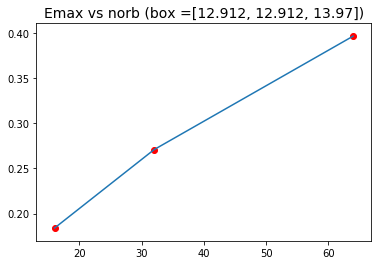

In [19]:
plt.plot(N,E)
plt.scatter(N,E, color='r')
plt.title('Emax vs norb (box ='+str(N2data[0].log['Sizes of the simulation domain']['Angstroem'])+')',fontsize=14)
plt.show()